### U-Net Like CNN for Image Segmentation - Keras Example

#### Obejective: Train a model that can genarate a segmentation mask of pets in images.

* Reference: https://keras.io/examples/vision/oxford_pets_image_segmentation/ by @fchollet

* Dataset Reference: Oxford's Visual Geometry Group: https://www.robots.ox.ac.uk/~vgg/data/pets/

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [ ]:
print(tf.config.list_physical_devices('GPU')) # Using Colabs

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Downloading Data:

In [ ]:
# Let's Create a folder to receive Data:

import os

os.mkdir('U-NetExData')
os.chdir('U-NetExData')

In [ ]:
# Collecting data:

!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  32.6M      0  0:00:23  0:00:23 --:--:-- 36.2M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  11.6M      0  0:00:01  0:00:01 --:--:-- 11.6M


In [ ]:
# Data Info:

img_size = (160, 160)
num_classes = 3
batch_size = 32

In [ ]:
### Let's organize data paths by checking their directories and sorting, matching images(inputs) to masks(targets):

os.chdir('/content/U-NetExData')

input_dir = "images/"
target_dir = "annotations/trimaps/"

## This is really good Python down below:

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


#### Let's Visualize how data looks like:

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
import random 

File Number: 10


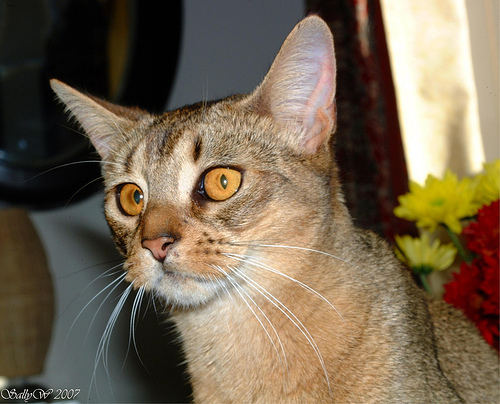

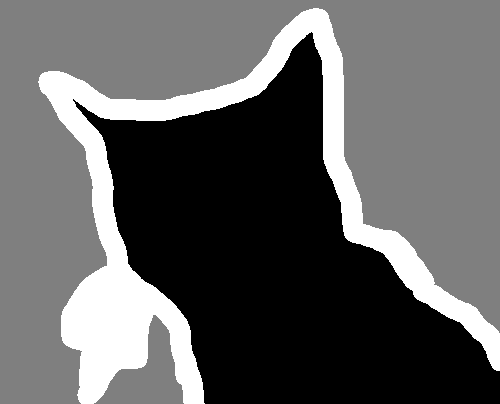

In [ ]:
# Display input image:

file_number = random.randint(1,10)

print('File Number:', file_number)

display(Image(filename=input_img_paths[file_number]))

# Displaying an auto-contrast of the target mask (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[file_number]))
display(img)

#### Let's Prepare a Sequence Class in order to to load and vectorize batches of our data:
* It's always better trying to iterate over data as arrays.

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):

        """Returns tuple (input, target) correspond to batch #index idx."""

        # Separate data batches by index:
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        # Inputs:
        # Create array:
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")

        # Fill array with imgs:
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img

        # Target:
        # Create array:
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")

        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1

        return x, y

#### Let's split data to get validation data:

In [ ]:
import random

# Split our img paths into a training and a validation set:
val_samples = 1000

# Shuffle data before split:
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths  = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths  = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split:
train_gen = OxfordPets(batch_size, img_size, train_input_img_paths, train_target_img_paths)

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)


#### Let's Prepate Tensorflow Model for a U-Net Xception-style CNN

![U-Net Architecture Example](https://929687.smushcdn.com/2407837/wp-content/uploads/2021/11/u-net_training_image_segmentation_models_in_pytorch_header.png?lossy=1&strip=1&webp=1)

[U-Net Architecture Example](https://929687.smushcdn.com/2407837/wp-content/uploads/2021/11/u-net_training_image_segmentation_models_in_pytorch_header.png?lossy=1&strip=1&webp=1)

In [ ]:
from tensorflow.keras import layers

# Build model method:

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

#### Model Training:

In [ ]:
# We use the "sparse" version of categorical_crossentropy because our target data is integers.

# Save best model callback and Tensorboard callback for vosualizaiton:
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_Unet_segmentation.h5", save_best_only=True),
    keras.callbacks.TensorBoard('./logs', update_freq=1)
]

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/15
199/199 [==============================] - 65s 245ms/step - loss: 0.9393 - val_loss: 2.2134
Epoch 2/15
199/199 [==============================] - 48s 242ms/step - loss: 0.5065 - val_loss: 2.5720
Epoch 3/15
199/199 [==============================] - 49s 244ms/step - loss: 0.4297 - val_loss: 0.4769
Epoch 4/15
199/199 [==============================] - 49s 245ms/step - loss: 0.3824 - val_loss: 0.4085
Epoch 5/15
199/199 [==============================] - 49s 246ms/step - loss: 0.3492 - val_loss: 0.3876
Epoch 6/15
199/199 [==============================] - 49s 245ms/step - loss: 0.3210 - val_loss: 0.4403
Epoch 7/15
199/199 [==============================] - 49s 245ms/step - loss: 0.2958 - val_loss: 0.4150
Epoch 8/15
199/199 [==============================] - 49s 245ms/step - loss: 0.2726 - val_loss: 0.4440
Epoch 9/15
199/199 [==============================] - 49s 245ms/step - loss: 0.2559 - val_loss: 0.3951
Epoch 10/15
199/199 [==============================] - 49s 247ms/step - l

In [ ]:

!tensorboard --logdir=/content/U-NetExData/


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.7.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


#### Let's Visualize Model Outputs:

Image: 1


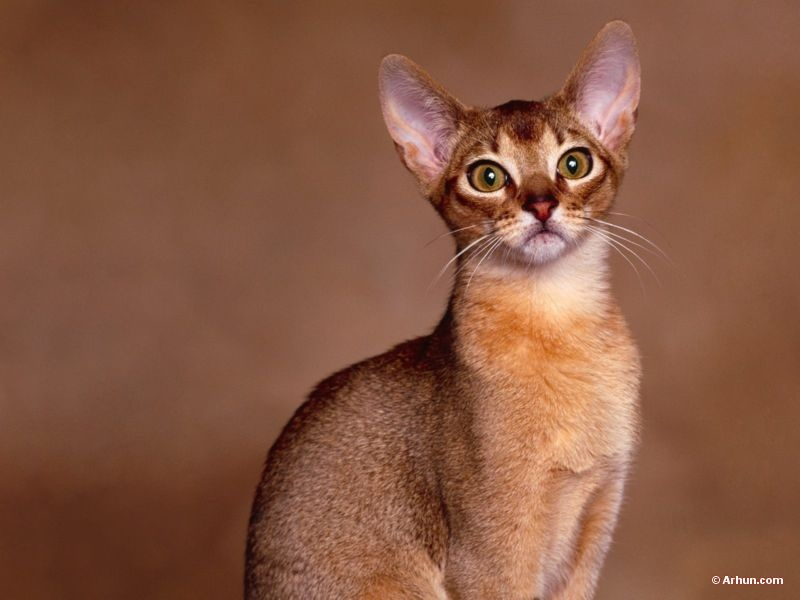

Ground-Truth Mask: 1


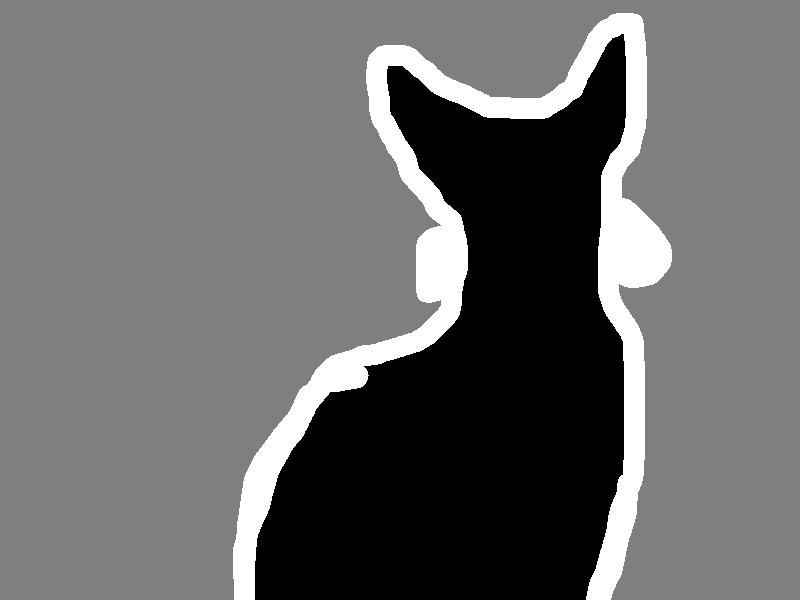

Model Output Mask 1


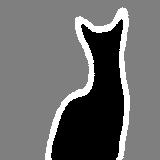

Image: 2


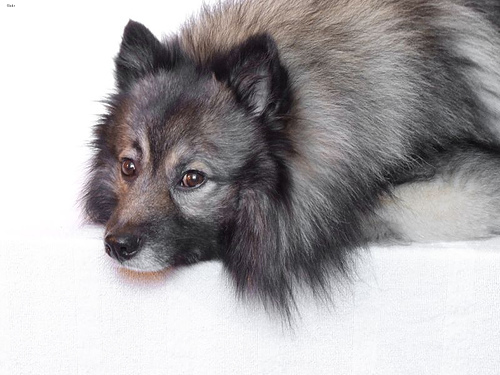

Ground-Truth Mask: 2


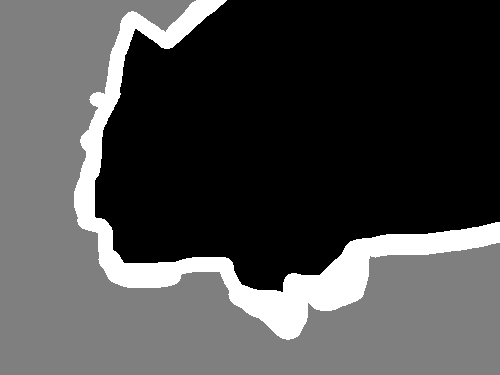

Model Output Mask 2


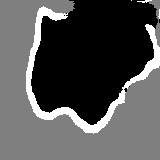

Image: 3


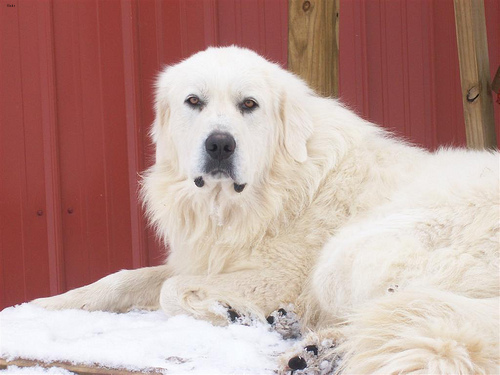

Ground-Truth Mask: 3


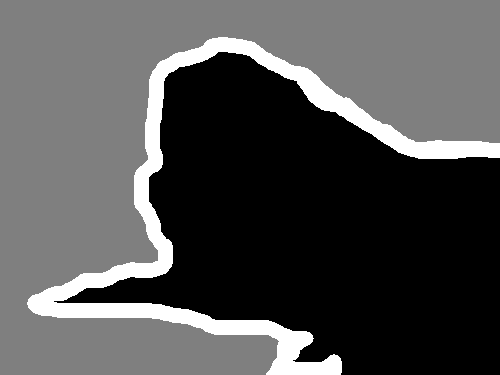

Model Output Mask 3


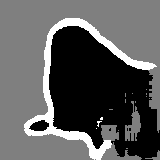

Image: 4


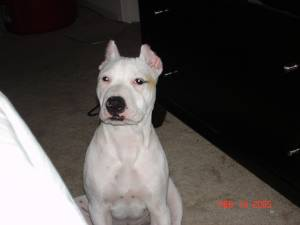

Ground-Truth Mask: 4


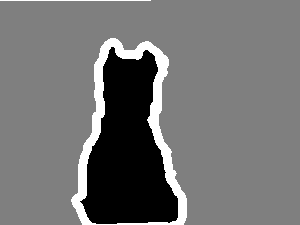

Model Output Mask 4


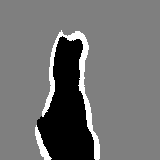

Image: 5


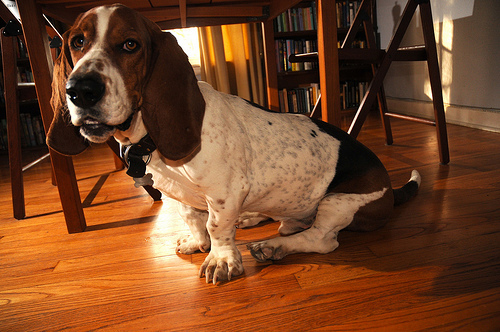

Ground-Truth Mask: 5


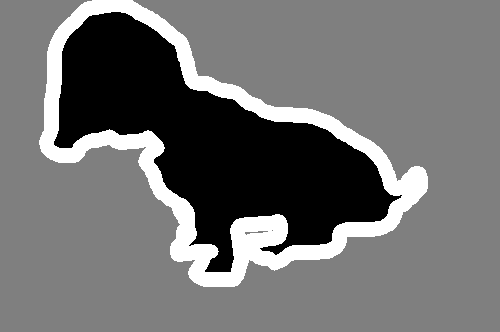

Model Output Mask 5


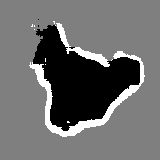

Image: 6


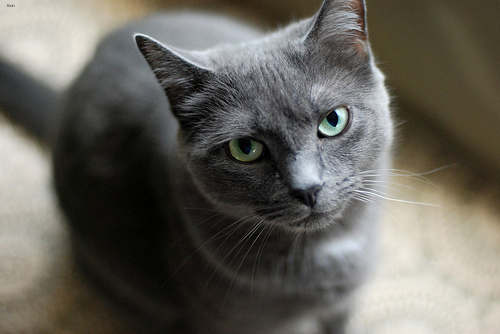

Ground-Truth Mask: 6


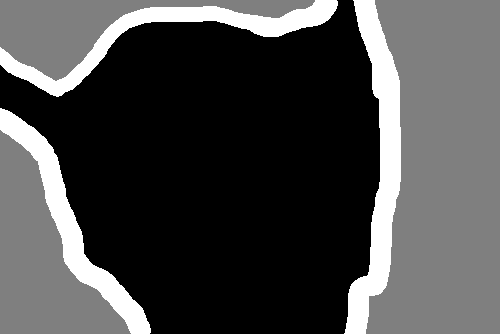

Model Output Mask 6


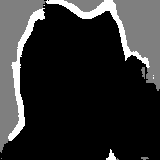

Image: 7


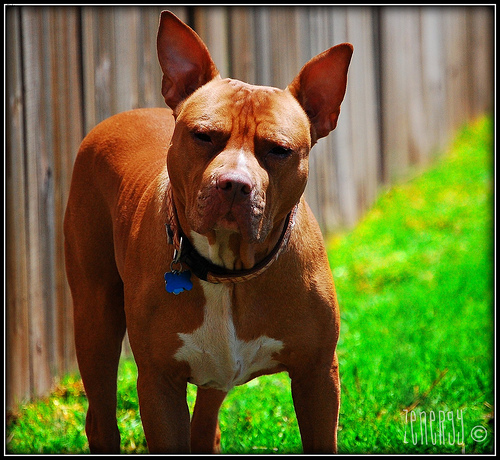

Ground-Truth Mask: 7


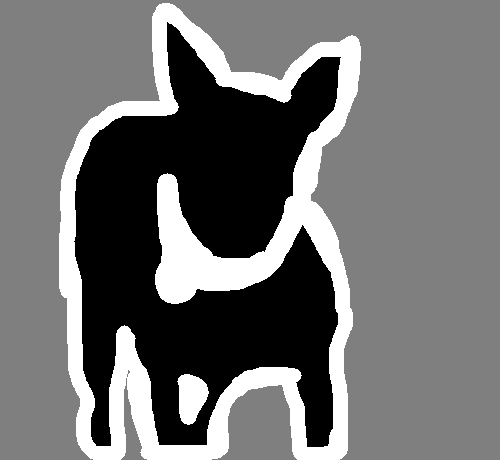

Model Output Mask 7


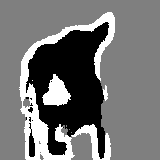

Image: 8


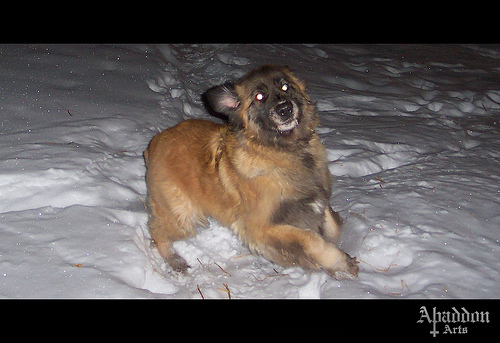

Ground-Truth Mask: 8


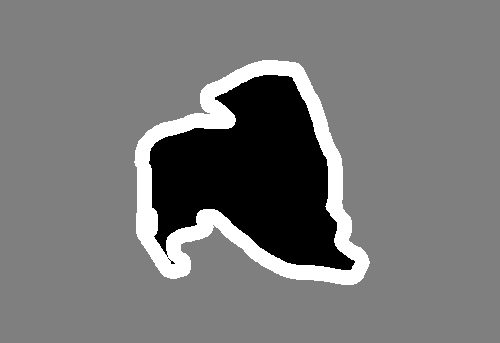

Model Output Mask 8


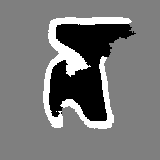

Image: 9


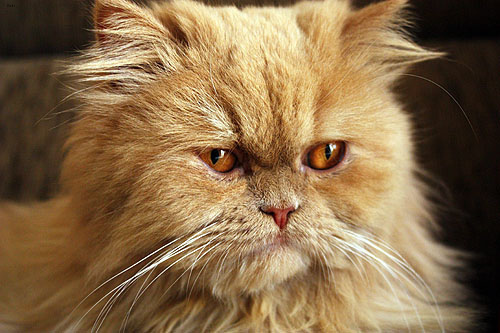

Ground-Truth Mask: 9


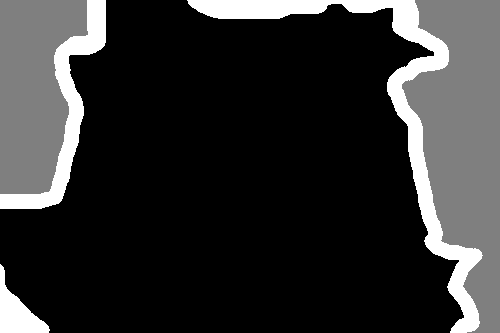

Model Output Mask 9


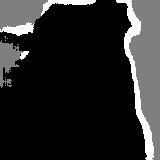

In [ ]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

def display_mask(i):
  """Quick utility to display a model's prediction."""
  mask = np.argmax(val_preds[i], axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
  display(img)

# Display results for validation images:

for i in range(1,10):

  # Display input image
  print('Image:', i)
  display(Image(filename=val_input_img_paths[i]))

  # Display ground-truth target mask
  print('Ground-Truth Mask:', i)
  img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
  display(img)

  # Display mask predicted by our model
  print('Model Output Mask', i)
  display_mask(i)  # Note that the model only sees inputs at 150x150.